# Homework 4: Evaluation Metrics for Classification

In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).

In this dataset our desired target for classification task will be converted variable - has the client signed up to the platform or not.

#### Data preparation

Check if the missing values are presented in the features.

If there are missing values:
* For caterogiral features, replace them with 'NA'
* For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [1]:
from pathlib import Path

import pandas as pd
import requests

from sklearn.model_selection import train_test_split


FILE_NAME = 'course_lead_scoring.csv'


In [2]:
def fetch():
    resp = requests.get(
        f'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/{FILE_NAME}',
        allow_redirects=False,
        timeout=10,
    )

    resp.raise_for_status()

    with open(FILE_NAME, 'w') as f:
        f.write(resp.text)

if not Path(FILE_NAME).exists():
    fetch()


In [3]:
df = pd.read_csv(FILE_NAME)
df.head()

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
df[categorical_columns] = df[categorical_columns].fillna('NA')
df.fillna(0, inplace=True)

df_full_train, df_val = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_test = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

###  Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* `lead_score`
* `number_of_courses_viewed`
* `interaction_count`
* `annual_income`

In [4]:
from sklearn.metrics import roc_auc_score

scores = {}
for col in ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    scores[col] = auc

max(scores, key=scores.get)

'number_of_courses_viewed'

### Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.32
* 0.52
* 0.72
* 0.92

In [5]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)


In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8196218702095044

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

For each threshold, compute precision and recall

Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [7]:
import numpy as np

thresholds = np.linspace(0, 1, 101)
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    scores.append((t, precision, recall))

columns = ['threshold', 'precision', 'recall']
df_metrics = pd.DataFrame(scores, columns=columns)

precisions = df_metrics['precision'].values
recalls = df_metrics['recall'].values

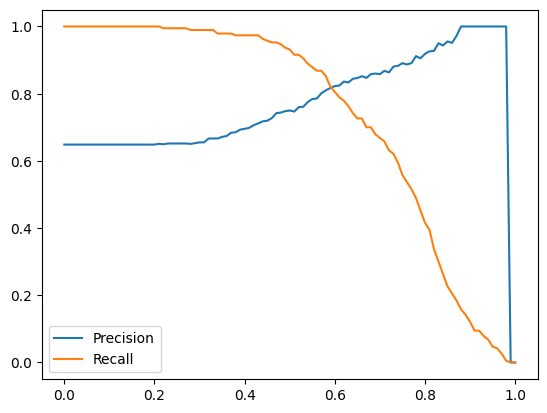

In [8]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.legend()

In [9]:
idx = np.argwhere(np.diff(np.sign(precisions - recalls))).flatten()
thresholds[idx[0]]

np.float64(0.59)

### Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`